Video gốc: https://www.youtube.com/watch?v=HypJY1XWkWY

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Bỏ video đã lấy phần người (nhóm sử dụng DeepLabv3 để phân đoạn ảnh). Link: https://github.com/jordankzf/human-silhouette-extractor/tree/main

In [ ]:
video_path = "sil_2.avi"
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Frames per second: {fps}")

Frames per second: 30.0


In [ ]:
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(frame)

cap.release()

In [ ]:
len(frames), frames[0].shape

(100, (360, 480))

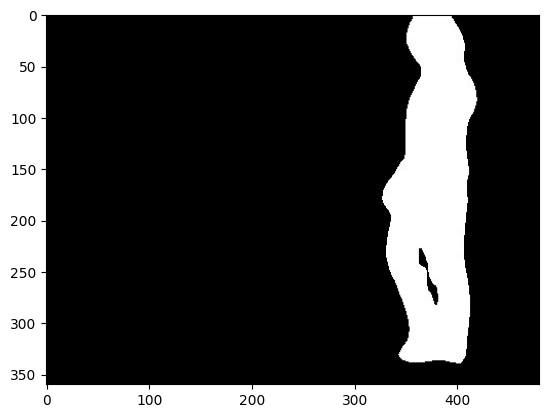

In [ ]:
test_frame = frames[10]
plt.imshow(test_frame, cmap='gray')

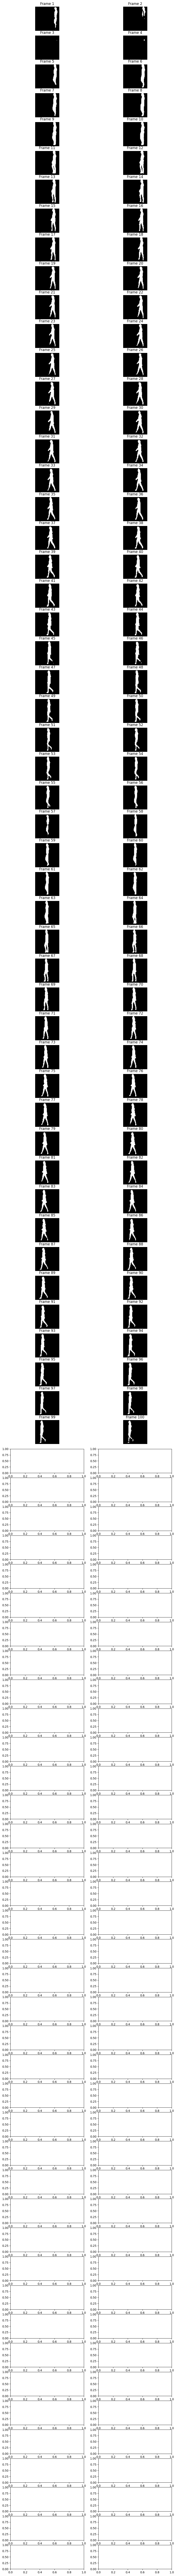

In [ ]:
fig, axes = plt.subplots(89, 2, figsize=(10, 160))
new_frames = []

for i, ax in enumerate(axes.flat):
    if i < len(frames):
        #x_start, y_start = 1130, 550
        #dist = 300
        #x_start += int(i * 1.5)
        #y_start += int(i // 2)
        #dist += int(i * 2 // 3)
        cropped_frame = frames[i]
        cropped_frame = cv2.resize(cropped_frame, (64, 64))
        new_frames.append(cropped_frame[10:-10,:])
        ax.imshow(cropped_frame, cmap="gray")
        ax.set_title(f"Frame {i + 1}")
        ax.axis("off")

# plt.tight_layout()
# plt.show()

In [ ]:
len(new_frames), new_frames[0].shape

(100, (44, 64))

In [ ]:
!git clone https://github.com/AbnerHqC/GaitSet.git

Cloning into 'GaitSet'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 106 (delta 29), reused 22 (delta 22), pack-reused 62 (from 1)
Receiving objects: 100% (106/106), 54.42 MiB | 22.44 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
import sys
sys.path.append("GaitSet")
from model.network import SetNet
import torch
import torch.nn as nn
import os.path as osp
from torchvision import transforms

In [ ]:
encoder = SetNet(256).float()
encoder = nn.DataParallel(encoder).cuda()
encoder.load_state_dict(torch.load(osp.join(
            'GaitSet',
            'work',
            'checkpoint',
            'GaitSet',
            'GaitSet_CASIA-B_73_False_256_0.2_128_full_30-80000-encoder.ptm')))

<All keys matched successfully>

In [ ]:
transform = transforms.ToTensor()
frames_tensor = torch.stack([transform(frame) for frame in new_frames])
frames_tensor = frames_tensor.unsqueeze(0).squeeze(2)
print(frames_tensor.shape)

torch.Size([1, 100, 44, 64])


In [ ]:
features, _ = encoder.forward(frames_tensor.cuda())

In [ ]:
print(features.view(-1).shape)
print(features)

torch.Size([15872])
tensor([[[-0.0136, -0.6234, -0.4504,  ...,  0.4613,  1.5479,  0.0573],
         [ 0.2410, -0.1665,  1.6740,  ...,  0.5134,  0.8068,  1.0558],
         [-0.4879,  0.7834,  0.6851,  ..., -1.0352,  0.6564, -0.5289],
         ...,
         [-0.0429,  0.3959,  0.4232,  ...,  0.5333,  0.2616, -0.6602],
         [ 0.0313, -0.2547,  0.2430,  ..., -0.1062,  0.2813, -0.0876],
         [ 0.2625, -0.4557,  0.1455,  ...,  0.3152, -0.0032, -0.6323]]],
       device='cuda:0', grad_fn=<PermuteBackward0>)


In [ ]:

loaded_features = torch.load('/content/drive/MyDrive/pbl4/gaitset_features.pt')
print(loaded_features['nm'].shape, loaded_features['cl'].shape, loaded_features['bg'].shape)

torch.Size([3287, 15872]) torch.Size([1100, 15872]) torch.Size([1098, 15872])


In [ ]:
def cuda_dist(x, y):
     return torch.norm(x - y, dim=0)

In [ ]:
flat = features.view(-1).cpu()

data = loaded_features['nm'][0]
print(flat.shape, data.shape)

min_label = 'nm'
min_dist = float('inf')

for data in loaded_features['nm']:
    dist = cuda_dist(flat, data)
    if dist < min_dist:
        min_dist = dist
        min_label = 'nm'

for data in loaded_features['cl']:
    dist = cuda_dist(flat, data)
    if dist < min_dist:
        min_dist = dist
        min_label = 'cl'

for data in loaded_features['bg']:
    dist = cuda_dist(flat, data)
    if dist < min_dist:
        min_dist = dist
        min_label = 'bg'

print(min_label, min_dist.item())

torch.Size([15872]) torch.Size([15872])
nm 73.53191375732422
